In [20]:
#Importação
#!pip install -U pandas-profiling
#!pip install pyspellchecker
#!pip install spellchecker
#!pip install spellcheck
#!pip install swifter==1.3.4 --user
#!pip install --upgrade --user pandas "dask[complete]"
#!pip install inexactsearch langdetect
#!pip3 install spellchecker
#!pip install prettytable

# To-Do:

- Comentar e refatorar código (Daniel)
- Inserir analise da base textual (Eduardo)
- Tratamento de texto voltado a negócio (Leonardo/Daniel)
- Treinar modelo Catboost Classifier (Herikc)
- Treinar modelo XGBoost (Leonardo)
- Treinar modelo de rede neural profunda (Sugestão: CNN) (Eduardo)
- Treinar modelo baseado em ngramas (sugestão: nayve bayes) (Herikc)
- Criar um site simples (sugestão: streamlit) (Angelo)
- Criar uma api para o site consumir (Angelo)

In [ ]:
#%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import unicodedata
import plotly.express as px
import plotly.graph_objects as go
import time
import swifter
import pickle
from keras.layers import Dropout
from nltk import ngrams
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, RegexpTokenizer
from itertools import chain

from nltk import bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics
from sklearn.metrics import accuracy_score
from swifter import set_defaults
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, cv
from prettytable import PrettyTable
from spellchecker import SpellChecker
import tqdm as notebook_tqd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud 
#tf.__version__

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leonardosteil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/leonardosteil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/leonardosteil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# Configurando swifter 
set_defaults(
    npartitions = None,
    dask_threshold = 1,
    scheduler = "processes",
    progress_bar = True,
    progress_bar_desc = None,
    allow_dask_on_strings = True,
    force_parallel = True,
)

In [26]:
# Em desenvolvimento
dev = False

In [27]:
#Importação base de dados
df = pd.read_csv(r'data/produtos_pre_tratamento.csv')
df.shape #Quantidade de linha e colunas do data frame

(9840, 2)

#Explorando a base de dados.
A análise da distribuição das categorias dos itens revela uma visão abrangente das diferentes classificações presentes. A categorização dos produtos é essencial para a organização e gestão eficiente do inventário. No contexto atual, foram identificadas quatro principais categorias de produtos:

Embalagem:

Quantidade: 3.416 itens Percentual: 34,72% A categoria "Embalagem" representa o maior segmento, compreendendo cerca de um terço (34,72%) do total de itens. Essa categoria inclui produtos essenciais para acondicionar e proteger os produtos, desempenhando um papel crucial na logística e no transporte.

EPI (Equipamentos de Proteção Individual):

Quantidade: 2.673 itens Percentual: 27,16% A categoria "EPI" é significativa, abrangendo aproximadamente 27,16% do total de itens. Esses equipamentos são essenciais para garantir a segurança e o bem-estar dos trabalhadores em diversas atividades, promovendo um ambiente laboral mais seguro.

Papelaria:

Quantidade: 2.364 itens Percentual: 24,02% A categoria "Papelaria" representa cerca de 24,02% do total de itens. Itens de papelaria são essenciais para as operações administrativas e organizacionais, sendo elementos básicos em escritórios e ambientes de trabalho.

Hidráulico:

Quantidade: 1.387 itens Percentual: 14,10% A categoria "Hidráulico" abrange aproximadamente 14,10% do total de itens. Itens hidráulicos são cruciais para sistemas e processos relacionados à distribuição e controle de água e fluidos.

Essa análise permite uma compreensão clara da composição do inventário, destacando a importância de cada categoria na estrutura geral do estoque. Isso pode ser valioso para a tomada de decisões estratégicas, otimização do estoque e atendimento às necessidades específicas do negócio.



In [28]:
# Listagem das categorias e as quantidades com percentual
contagem_categoria = df['Categoria'].value_counts()
total = len(df)  # Total de ite ns

for categoria, quantidade in contagem_categoria.items():
    porcentagem = (quantidade / total) * 100
    print(f"Categoria: {categoria}, Quantidade: {quantidade}, Percentual: {porcentagem:.2f}%")

Categoria: Embalagem, Quantidade: 3416, Percentual: 34.72%
Categoria: Epi, Quantidade: 2673, Percentual: 27.16%
Categoria: Papelaria, Quantidade: 2364, Percentual: 24.02%
Categoria: Hidráulico, Quantidade: 1387, Percentual: 14.10%


In [29]:
# Calcular o total de itens
total = len(df)

# Calcular o percentual e a quantidade para cada categoria
porcentagens = []
quantidades = []
categorias = []
labels = []  # Lista para armazenar os rótulos
for categoria, grupo in df.groupby('Categoria'):
    quantidade = len(grupo)
    porcentagem = (quantidade / total) * 100
    porcentagens.append(porcentagem)
    quantidades.append(quantidade)
    categorias.append(categoria)
    labels.append(f'{categoria}<br>({quantidade} itens)')

# Cores para cada categoria
cores = ['blue', 'orange', 'green', 'red']

# Ajustar os raios para 80% da área
raio_externo = 0.4  # Raio externo para 80% da área
raio_interno = raio_externo - 0.02  # Raio interno para criar o "anel"

# Criar o gráfico de pizza
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=porcentagens,
                             textinfo='label+percent',  # Exibir rótulos e percentuais
                             hole=raio_interno,  # Raio interno
                             marker=dict(colors=cores))])

# Adicionar título e ajustar layout
fig.update_layout(title_text=f'Distribuição dos Itens por Categorias - Total: {total}',
                  margin=dict(t=50, b=50, l=50, r=50))  # Margens para remover espaços desnecessários

# Mostrar o gráfico
fig.show()

Analise coluna descrição.
Antes de inicar analise vamos fazer um pre processamento 

In [30]:
dfManipulated = df.copy()

In [31]:
# pyspellchecker
spell = SpellChecker(language='pt')

def pyspellchecker(text):
    word_list = word_tokenize(text, language = 'portuguese')
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list) and len(word) > 3:
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

In [32]:
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [33]:
def limpar_texto(text):
   text = str(text)

    # Remover caracteres non-ascii
   text = ''.join(caracter for caracter in text if ord(caracter) < 128)

    # Convertendo para lower case
   text = text.lower()

    # Removendo pontuação por expressão regular
   regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
   text = regex.sub(' ', str(text))

   text = re.sub('[^A-Za-z ]+', '', text)

    # Carregando stopwords em português
   portuguese_stops = set(stopwords.words('portuguese'))

    # Removendo stopwords em português
    # Mantendo somente palavras que não são consideradas stopwords
   text = ' '.join(palavra for palavra in text.split() if palavra not in portuguese_stops)

    # Remover palavras com menos de 2 caracteres
   words = text.split()
   text = [word for word in words if len(word) > 2 or word == ' ']
   text = ' '.join(text)

    # Corrigindo erros gramaticais
   text = pyspellchecker(text)

    # Criando a estrutura baseada em uma wordnet para lemmatization
   wordnet_lemmatizer = WordNetLemmatizer()
   # Aplicando Lemmatization
   text = ' '.join(wordnet_lemmatizer.lemmatize(palavra) for palavra in text.split())

    # Remover palavras com menos de 2 caracteres residuais
   words = text.split()
   text = [word for word in words if len(word) > 2 or word == ' ']
   text = ' '.join(text)

   text = strip_accents(text)

   return text

In [34]:
%%time
print('Tratanto texto...')
dfManipulated['descricao'] = dfManipulated['descricao'].map(limpar_texto)
print('Texto tratado')

Tratanto texto...
Texto tratado
CPU times: user 45min 30s, sys: 292 ms, total: 45min 31s
Wall time: 45min 31s


In [35]:
# Exporte o DataFrame para um arquivo CSV
dfManipulated.to_csv('data/dfPreProcessado.csv', index=False)

In [21]:
df = pd.read_csv(r'data/dfPreProcessado.csv')

In [23]:
df

,descricao,Categoria
0,caneta bic cristal azul,Papelaria
1,caneta bic cristal azul filial,Papelaria
2,caneta bic cristal preta,Papelaria
3,caneta bic cristal preta filial,Papelaria
4,caneta bic cristal vermelha,Papelaria
...,...,...
9835,luva educado galo luva educado galvanizada,Hidráulico
9836,luva educado galo luva educado galvanizada,Hidráulico
9837,luva educado galo luva educado galvanizada,Hidráulico
9838,luva educado galo luva educado galvanizada,Hidráulico


In [24]:
def exibir_descricao(filtro=None):
    if filtro:
        descricao_filtrada = df[df['descricao'].str.contains(filtro, case=False)]
        descricao_list = descricao_filtrada['descricao'].tolist()
    else:
        descricao_list = df['descricao'].sample(10).tolist()  # Seleciona 10 itens aleatórios

    # Criar uma tabela com alinhamento à esquerda
    tabela = PrettyTable()
    tabela.field_names = ['Descrição']
    tabela.align['Descrição'] = 'l'  # Alinha à esquerda

    # Adicionar as descrições à tabela
    for descricao in descricao_list:
        tabela.add_row([descricao])

    # Exibir a tabela
    print(tabela)

In [25]:
# Exibir a descrição com base no filtro ou 10 itens aleatórios pode ser passar frase especifica por paramentro
exibir_descricao()

+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| Descrição                                                                                                                                             |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
| luva nitrisolv danny tam                                                                                                                              |
| luva neoprene sob latex leal tam                                                                                                                      |
| bota termina velcro micro composto soldado latex                                                                                                      |
| luva temperatura sinto azul tamanho produto servico utilizar padre epi sta

In [8]:
#Criação de um csv com as decrições repetidas

# Limpeza dos espaços no início e final das frases
df['descricao'] = df['descricao'].str.strip()

# Identificação de frases repetidas
frases_repetidas = df[df.duplicated('descricao', keep=False)]

# Contagem das frases repetidas
contagem_frases_repetidas = frases_repetidas['descricao'].value_counts()

# Criar um DataFrame com a quantidade e descrição repetida
df_contagem = pd.DataFrame({'descricao_repetida': contagem_frases_repetidas.index,
                            'quantidade': contagem_frases_repetidas.values})

# Adicionar coluna com frase e quantidade
df_contagem['frase_quantidade'] = df_contagem.apply(lambda row: f"{row['descricao_repetida']}, Quantidade: {row['quantidade']}", axis=1)

# Exibir as frases repetidas e suas contagens
#print("Frases repetidas e suas contagens:")
#print(df_contagem)

# Exportar para CSV
df_contagem.to_csv('data/frases_repetidas.csv', columns=['frase_quantidade'], index=False)
print("Csv Frases repetidas e suas contagens criado na pasta data.")

Csv Frases repetidas e suas contagens criado na pasta data.


In [9]:
#verificando se a frase pernteçe a mais de uma categoria
# Limpeza dos espaços no início e final das frases
df['descricao'] = df['descricao'].str.strip()

# Contar quantas vezes cada frase aparece para diferentes categorias
contagem_frases_por_categoria = df.groupby(['descricao', 'Categoria']).size().reset_index(name='contagem')

# Filtrar frases que aparecem em mais de uma categoria
frases_em_mais_de_uma_categoria = contagem_frases_por_categoria[contagem_frases_por_categoria.duplicated('descricao', keep=False)]

# Exibir as frases que aparecem em mais de uma categoria
print("Frases que aparecem em mais de uma categoria:")
print(frases_em_mais_de_uma_categoria)
print("Criado o CSV frases que aparecem em mais de uma categoria")
frases_em_mais_de_uma_categoria.to_csv('data/frases_em_mais_de_uma_categoria.csv', index=False)

Frases que aparecem em mais de uma categoria:
                                              descricao  Categoria  contagem
76    bobina kbm papel bco klabin bobina kbm papel b...  Embalagem         5
77    bobina kbm papel bco klabin bobina kbm papel b...  Papelaria         1
80          bobina papel calculadora mmm datapel careca  Embalagem         1
81          bobina papel calculadora mmm datapel careca  Papelaria         1
82                            bobina papel cartao ponto  Embalagem         1
...                                                 ...        ...       ...
5794                      uso rec papel bob strong liso  Papelaria         1
5828                        velamoide metro junta papel  Embalagem         2
5829                        velamoide metro junta papel  Papelaria         2
5830                            velumoide papel guarita  Embalagem         1
5831                            velumoide papel guarita  Papelaria         1

[914 rows x 3 columns]
Criado

In [10]:
def contar_ocorrencias_galv(texto):
    # Utilizamos uma expressão regular para encontrar o padrão 'GALV' ou 'galv' com a possibilidade de um ponto após a última letra
    padrao = re.compile(r'(?i)GALV\.?')
    return len(padrao.findall(texto))

# Aplicar a função a cada linha da coluna 'descricao'
df['contagem_galv'] = df['descricao'].apply(contar_ocorrencias_galv)

# Calcular o total de ocorrências de 'GALV' (maiúscula ou minúscula) com a possibilidade de um ponto após a última letra
total_ocorrencias_galv = sum(df['contagem_galv'])

# Exibir o total de ocorrências
print('Total de ocorrências de "GALV" (com ou sem ponto após a última letra):', total_ocorrencias_galv)

Total de ocorrências de "GALV" (com ou sem ponto após a última letra): 414


In [11]:
# Função para identificar palavras iguais em sequência e contar sua ocorrência
def identificar_palavras_iguais(texto):
    # Encontrar padrões de duas ou mais palavras iguais em sequência
    padrao = r'\b(\w+)\s+\1\b'
    palavras_iguais = re.findall(padrao, texto, flags=re.IGNORECASE)
    quantidade = len(palavras_iguais)
    
    return palavras_iguais, quantidade

# Identificar palavras iguais em sequência e contar a quantidade para cada descrição
df[['palavras_iguais', 'quantidade']] = df['descricao'].apply(lambda x: pd.Series(identificar_palavras_iguais(x), index=['palavras_iguais', 'quantidade']))

# Filtrar e exibir apenas as linhas com palavras duplicadas
df_com_palavras_duplicadas = df[df['quantidade'] > 0]

# Criar um DataFrame para o CSV contendo as palavras duplicadas e a frase correspondente
df_csv = pd.DataFrame({'Palavra_Duplicada': df_com_palavras_duplicadas['palavras_iguais'].apply(lambda x: x[0]),
                       'Frase': df_com_palavras_duplicadas['descricao']})

# Salvar o DataFrame em um arquivo CSV
df_csv.to_csv('data/palavras_duplicadas.csv', index=False)

print("Arquivo CSV 'palavras_duplicadas.csv' criado com sucesso.")

Arquivo CSV 'palavras_duplicadas.csv' criado com sucesso.


In [12]:
# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv('data/palavras_duplicadas.csv')

# Calcular a quantidade de ocorrências para cada palavra duplicada
contagem_palavras = df['Palavra_Duplicada'].value_counts()

# Filtrar para palavras com quantidade maior que 50 e menor ou igual a 50
maior_que_50 = contagem_palavras[contagem_palavras > 50]
menor_ou_igual_a_50 = contagem_palavras[contagem_palavras <= 50]

# Criar o gráfico para quantidade maior que 50
fig_maior_que_50 = go.Figure(go.Bar(
    y=maior_que_50.index,
    x=maior_que_50.values,
    orientation='h',
    text=maior_que_50.values,
    textposition='auto',
    hoverinfo='text',
    marker=dict(color='royalblue')
))

fig_maior_que_50.update_layout(
    title='Quantidade de Palavras Duplicadas (Quantidade > 50)',
    xaxis_title='Quantidade',
    yaxis_title='Palavra Duplicada',
    template='plotly_white'
)

# Criar o gráfico para quantidade menor ou igual a 50
fig_menor_ou_igual_a_50 = go.Figure(go.Bar(
    y=menor_ou_igual_a_50.index,
    x=menor_ou_igual_a_50.values,
    orientation='h',
    text=menor_ou_igual_a_50.values,
    textposition='auto',
    hoverinfo='text',
    marker=dict(color='purple')
))

fig_menor_ou_igual_a_50.update_layout(
    title='Quantidade de Palavras Duplicadas (Quantidade <= 50)',
    xaxis_title='Quantidade',
    yaxis_title='Palavra Duplicada',
    template='plotly_white'
)

# Exibir os gráficos
fig_maior_que_50.show()
fig_menor_ou_igual_a_50.show()

In [13]:
#Remover plavras iguias em sequencia exemplo cor cor
def remover_palavras_iguais_em_sequencia(texto):
    # Usando expressão regular para encontrar palavras repetidas em sequência
    padrao = r'\b(\w+)\b\s+\1\b'
    texto_sem_repeticao = re.sub(padrao, r'\1', texto, flags=re.IGNORECASE)
    return texto_sem_repeticao

df = pd.read_csv(r'data/dfPreProcessado.csv')

# Aplicar a função para remover palavras iguais em sequência na coluna "descricao"
df['descricao'] = df['descricao'].apply(remover_palavras_iguais_em_sequencia)

# Exibir o DataFrame resultante
print(df)

                                              descricao   Categoria
0                               caneta bic cristal azul   Papelaria
1                        caneta bic cristal azul filial   Papelaria
2                              caneta bic cristal preta   Papelaria
3                       caneta bic cristal preta filial   Papelaria
4                           caneta bic cristal vermelha   Papelaria
...                                                 ...         ...
9835         luva educado galo luva educado galvanizada  Hidráulico
9836         luva educado galo luva educado galvanizada  Hidráulico
9837         luva educado galo luva educado galvanizada  Hidráulico
9838         luva educado galo luva educado galvanizada  Hidráulico
9839  luva educado galo femea luva educado galvaniza...  Hidráulico

[9840 rows x 2 columns]


In [14]:
# Função para identificar palavras-chave em uma descrição manual informe a palavra no array palavras_chave 
# 
def identificar_palavras_chave(descricao):

    palavras_chave = ['filial', 'vender', 'fort', 'miguel','uso']
    presentes = {palavra: descricao.lower().count(palavra) for palavra in palavras_chave}
    return presentes

df = pd.read_csv(r'data/dfPreProcessado.csv')

# Calcular a quantidade de cada palavra-chave encontrada
df['palavras_chave_quantidade'] = df['descricao'].apply(identificar_palavras_chave)

# Calcular a soma da quantidade de cada palavra-chave
soma_palavras_chave = df['palavras_chave_quantidade'].apply(pd.Series).sum().sort_values()

# Criar um gráfico de barras verticais com plotly
fig = go.Figure(go.Bar(
    y=soma_palavras_chave.index,
    x=soma_palavras_chave.values,
    text=soma_palavras_chave.values,
    textposition='auto',
    marker_color='royalblue',
    orientation='h',
))

fig.update_layout(
    title='Quantidade de cada Palavra-chave',
    xaxis_title='Palavra-chave',
    yaxis_title='Quantidade',
    template='plotly_white'
)

# Exibir o gráfico
fig.show()





In [26]:
df = pd.read_csv(r'data/dfPreProcessado.csv')
from collections import Counter
# Função para contar palavras de até 3 caracteres
def contar_palavras_ate_3_caracteres(texto):
    palavras = texto.lower().split()
    palavras_ate_3 = [palavra for palavra in palavras if len(palavra) == 3]
    return Counter(palavras_ate_3)


# Calcular a contagem de palavras de até 3 caracteres em todas as descrições
contagem_palavras = Counter()
for descricao in df['descricao']:
    contagem_palavras += contar_palavras_ate_3_caracteres(descricao)

# Filtrar palavras com quantidade maior que 500 ou maior que 100
palavras_maior_500 = {palavra: contagem_palavras[palavra] for palavra in contagem_palavras if contagem_palavras[palavra] > 500}
palavras_maior_100 = {palavra: contagem_palavras[palavra] for palavra in contagem_palavras if 100 < contagem_palavras[palavra] <= 500}
palavras_menor_100 = {palavra: contagem_palavras[palavra] for palavra in contagem_palavras if contagem_palavras[palavra] <= 100}

# Criar um gráfico de barras para quantidade maior que 500
fig_maior_500 = go.Figure(go.Bar(
    y=list(palavras_maior_500.keys()),
    x=list(palavras_maior_500.values()),
    text=list(palavras_maior_500.values()),
    textposition='auto',
    marker_color='royalblue',
    orientation='h',
))

fig_maior_500.update_layout(
    title='Quantidade de Palavras com mais de 500 ocorrências',
    xaxis_title='Palavra',
    yaxis_title='Quantidade',
    template='plotly_white'
)

# Criar um gráfico de barras para quantidade entre 100 e 500
fig_entre_100_e_500 = go.Figure(go.Bar(
    y=list(palavras_maior_100.keys()),
    x=list(palavras_maior_100.values()),
    text=list(palavras_maior_100.values()),
    textposition='auto',
    marker_color='purple',
    orientation='h',
))

fig_entre_100_e_500.update_layout(
    title='Quantidade de Palavras com mais de 100 e até 500 ocorrências',
    xaxis_title='Palavra',
    yaxis_title='Quantidade',
    template='plotly_white'
)

# Criar um gráfico de barras para quantidade menor que 100
fig_menor_100 = go.Figure(go.Bar(
    y=list(palavras_menor_100.keys()),
    x=list(palavras_menor_100.values()),
    text=list(palavras_menor_100.values()),
    textposition='auto',
    marker_color='green',
    orientation='h',
))

fig_menor_100.update_layout(
    title='Quantidade de Palavras com até 100 ocorrências',
    xaxis_title='Palavra',
    yaxis_title='Quantidade',
    template='plotly_white'
)

# Exibir os gráficos
fig_maior_500.show()
fig_entre_100_e_500.show()
fig_menor_100.show()

In [27]:
# Criado esta função para remover as palavras desejada a atualizado o dataframe
# Para remover uma palavra adicione as palavras que deseja remover no array
stop_words_personalizadas = ['ete', 'ftc', 'xxm','ref'
                             'saw', 'shp','uso',
                             'filial','preto','preta','vermelho','vermelha', 'azul', 'verde', 'amarelo', 'laranja']
def remover_stop_words(texto):
    # Padroniza a lista de stop words para garantir que a comparação seja insensível a maiúsculas e minúsculas
    stop_words = [re.escape(word.lower()) for word in stop_words_personalizadas]
    # Cria uma expressão regular para encontrar as stop words
    padrao = r'\b(?:' + '|'.join(stop_words) + r')\b'
    # Remove as stop words do texto
    texto_sem_stop_words = re.sub(padrao, '', texto, flags=re.IGNORECASE)
    return texto_sem_stop_words


df = pd.read_csv(r'data/dfPreProcessado.csv')
df['descricao'] = df['descricao'].apply(remover_stop_words)
# Exibir o DataFrame resultante
print(df)

                                              descricao   Categoria
0                                   caneta bic cristal    Papelaria
1                                  caneta bic cristal     Papelaria
2                                   caneta bic cristal    Papelaria
3                                  caneta bic cristal     Papelaria
4                                   caneta bic cristal    Papelaria
...                                                 ...         ...
9835         luva educado galo luva educado galvanizada  Hidráulico
9836         luva educado galo luva educado galvanizada  Hidráulico
9837         luva educado galo luva educado galvanizada  Hidráulico
9838         luva educado galo luva educado galvanizada  Hidráulico
9839  luva educado galo femea luva educado galvaniza...  Hidráulico

[9840 rows x 2 columns]


In [28]:

#função criada para fazer replace em massa das palavras
def replace_em_massa_dataframe(df, coluna, vetor_valores_substituir, vetor_novos_valores):
    # Garante que os tamanhos dos vetores são iguais
    if len(vetor_valores_substituir) != len(vetor_novos_valores):
        raise ValueError("Os vetores de substituição devem ter o mesmo tamanho")

    # Cria um dicionário de substituições
    substituicoes = dict(zip(vetor_valores_substituir, vetor_novos_valores))

    # Aplica as substituições na coluna "descricao"
    df[coluna] = df[coluna].replace(substituicoes, regex=True)

    return df

# Passe as palavras neste array 
vetor_valores_substituir = ["canetass",
                            "luvas",
                            "filial",
                            "GALV",                          
                            ]

vetor_novos_valores = ["caneta", 
                       "luva",
                       "",
                       "galvanizada",                       
                     ]

df = replace_em_massa_dataframe(df, 'descricao', vetor_valores_substituir, vetor_novos_valores)

# Exibir o DataFrame resultante
print(df)




                                              descricao   Categoria
0                                   caneta bic cristal    Papelaria
1                                  caneta bic cristal     Papelaria
2                                   caneta bic cristal    Papelaria
3                                  caneta bic cristal     Papelaria
4                                   caneta bic cristal    Papelaria
...                                                 ...         ...
9835         luva educado galo luva educado galvanizada  Hidráulico
9836         luva educado galo luva educado galvanizada  Hidráulico
9837         luva educado galo luva educado galvanizada  Hidráulico
9838         luva educado galo luva educado galvanizada  Hidráulico
9839  luva educado galo femea luva educado galvaniza...  Hidráulico

[9840 rows x 2 columns]


In [29]:

df_copia = df
df_copia['descricao'] = df_copia['descricao'].str.strip()

# Remover frases duplicadas
df_sem_duplicatas = df_copia.drop_duplicates(subset=['descricao'])

# Exibir DataFrame sem frases duplicadas
print("DataFrame sem frases duplicadas:")
print(df_sem_duplicatas)

DataFrame sem frases duplicadas:
                                              descricao   Categoria
0                                    caneta bic cristal   Papelaria
6                                      caneta bps pilot   Papelaria
7        caneta marcador permanente acrilex ponta dupla   Papelaria
8                  caneta retocar madeira branco corcel   Papelaria
9     caneta retroprojetor manter fazer castelo pont...   Papelaria
...                                                 ...         ...
9813                         luva galo luva galvanizada  Hidráulico
9821                         luva galo luva galvanizado  Hidráulico
9825         luva educado galo luva educado galvanizada  Hidráulico
9834  luva educado galo luva educado galvanizada pol...  Hidráulico
9839  luva educado galo femea luva educado galvaniza...  Hidráulico

[5071 rows x 2 columns]


In [18]:
df.head()

,descricao,Categoria,palavras_chave_quantidade
0,caneta bic cristal azul,Papelaria,"{'filial': 0, 'vender': 0, 'fort': 0, 'miguel'..."
1,caneta bic cristal azul filial,Papelaria,"{'filial': 1, 'vender': 0, 'fort': 0, 'miguel'..."
2,caneta bic cristal preta,Papelaria,"{'filial': 0, 'vender': 0, 'fort': 0, 'miguel'..."
3,caneta bic cristal preta filial,Papelaria,"{'filial': 1, 'vender': 0, 'fort': 0, 'miguel'..."
4,caneta bic cristal vermelha,Papelaria,"{'filial': 0, 'vender': 0, 'fort': 0, 'miguel'..."


In [30]:
df = df.rename({'categoria': 'Categoria'}, axis = 1)

In [53]:
#df['Categoria'] = df['Nova cat 1'] + ' - ' + df['Nova cat 2'] + ' - ' + df['Nova cat 3']

In [31]:
df = df[['descricao', 'Categoria']]

In [32]:
df.dtypes

descricao    object
Categoria    object
dtype: object

In [33]:
df = df[df['Categoria'] != 'Não Classificado - Não Classificado - Não Classificado']

In [34]:
df.shape

(9840, 2)

In [35]:
df.head()

,descricao,Categoria
0,caneta bic cristal,Papelaria
1,caneta bic cristal,Papelaria
2,caneta bic cristal,Papelaria
3,caneta bic cristal,Papelaria
4,caneta bic cristal,Papelaria


In [36]:
dfManipulated = df.copy()

In [37]:
# pyspellchecker
spell = SpellChecker(language='pt')

def pyspellchecker(text):
    word_list = word_tokenize(text, language = 'portuguese')
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list) and len(word) > 3:
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

In [38]:
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [39]:
def limpar_texto(text):
    # Convertendo para str
    text = str(text)

    # Remover caracteres non-ascii
    text = ''.join(caracter for caracter in text if ord(caracter) < 128)

    # Convertendo para lower case
    text = text.lower()

    # Removendo pontuação por expressão regular
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    text = regex.sub(' ', str(text))

    text = re.sub('[^A-Za-z ]+', '', text)

    # Carregando stopwords em português
    portuguese_stops = set(stopwords.words('portuguese'))

    # Removendo stopwords em português
    # Mantendo somente palavras que não são consideradas stopwords
    text = ' '.join(palavra for palavra in text.split() if palavra not in portuguese_stops)

    # Remover palavras com menos de 2 caracteres
    words = text.split()
    text = [word for word in words if len(word) > 2 or word == ' ']
    text = ' '.join(text)

    # Corrigindo erros gramaticais
    text = pyspellchecker(text)

    # Criando a estrutura baseada em uma wordnet para lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    # Aplicando Lemmatization
    text = ' '.join(wordnet_lemmatizer.lemmatize(palavra) for palavra in text.split())

    # Remover palavras com menos de 2 caracteres residuais
    words = text.split()
    text = [word for word in words if len(word) > 2 or word == ' ']
    text = ' '.join(text)

    text = strip_accents(text)

    return text

In [40]:
%%time

if not dev:
    print('Tratanto texto...')
    dfManipulated['descricao'] = dfManipulated['descricao'].swifter.apply(limpar_texto)
    print('Texto tratado')
    dfManipulated.to_csv('data/produtos_pos_tratamento.csv', index=False)
else:
    dfManipulated = pd.read_csv(r'data/produtos_pos_tratamento.csv')
    dfManipulated = dfManipulated[['descricao', 'Categoria']]
    
    with open('models/label_encoder.pkl', 'rb') as file:
        le = pickle.load(file)
    
    le.inverse_transform(dfManipulated['Categoria'])

NameError: name 'dev' is not defined

In [63]:
dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(0, 'Embalagem')
dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(1, 'Epi')
dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(2, 'Papelaria')
dfManipulated['Categoria'] = dfManipulated['Categoria'].replace(3, 'Hidráulico')

In [64]:
df.iloc[4][0]

'caneta bic cristal'

In [65]:
dfManipulated.iloc[4][0]

'caneta bic cristal'

In [66]:
# Verificando dimensionalidade
print(dfManipulated.shape)

# Existe NAs
print(dfManipulated.isna().sum())

# Existe duplicados
print(dfManipulated.duplicated().sum())

# Removendo duplicados
dfManipulated.drop_duplicates(inplace=True)

# Verificando dimensionalidade final
print(dfManipulated.shape)

(9840, 2)
descricao    0
Categoria    0
dtype: int64
4351
(5489, 2)


In [67]:
print("Distribuição das classes \n\n", dfManipulated.Categoria.value_counts())

Distribuição das classes 

 Categoria
Embalagem     1920
Papelaria     1558
Epi           1290
Hidráulico     721
Name: count, dtype: int64


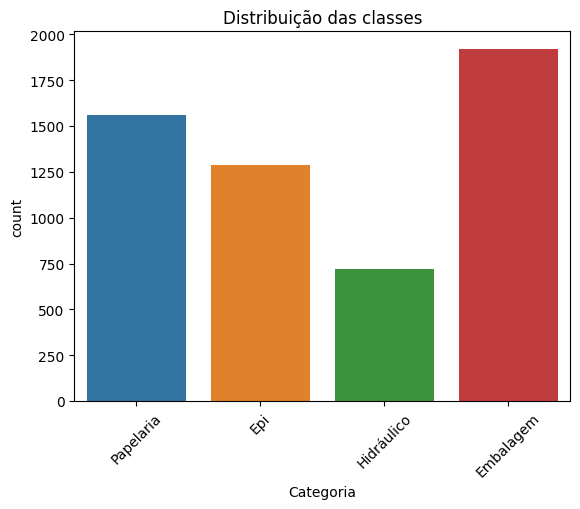

In [68]:
sns.countplot(data=dfManipulated, x="Categoria")
plt.title("Distribuição das classes")
plt.xticks(rotation=45)
plt.show()

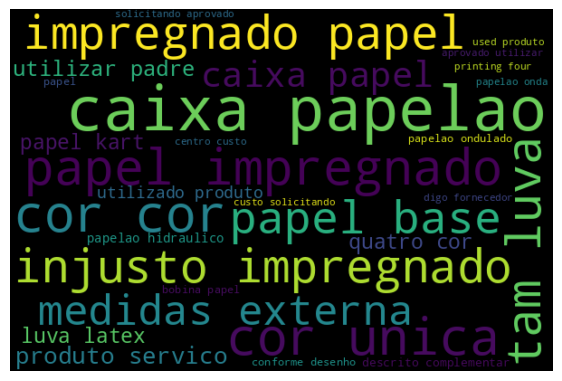

In [69]:
wordcloud = WordCloud(width = 600, height = 400, max_words=30).generate_from_text(\
                                                                ' '.join(dfManipulated['descricao']))
plt.figure(figsize = (7, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [70]:
unique_values = dfManipulated['Categoria'].unique()

print("Unique values in", 'Categoria', "column:", unique_values, sep='\n')

Unique values in
Categoria
column:
['Papelaria' 'Epi' 'Hidráulico' 'Embalagem']


In [ ]:
def generate_wordcloud(categoria):
  global dfManipulated

  dfTemp = dfManipulated.loc[dfManipulated['Categoria'] == categoria]

  wordcloud = WordCloud(width = 600, height = 400, max_words=30).generate_from_text(' '.join(dfTemp['descricao']))
  plt.figure(figsize = (7, 7))
  plt.title(categoria)
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.show()

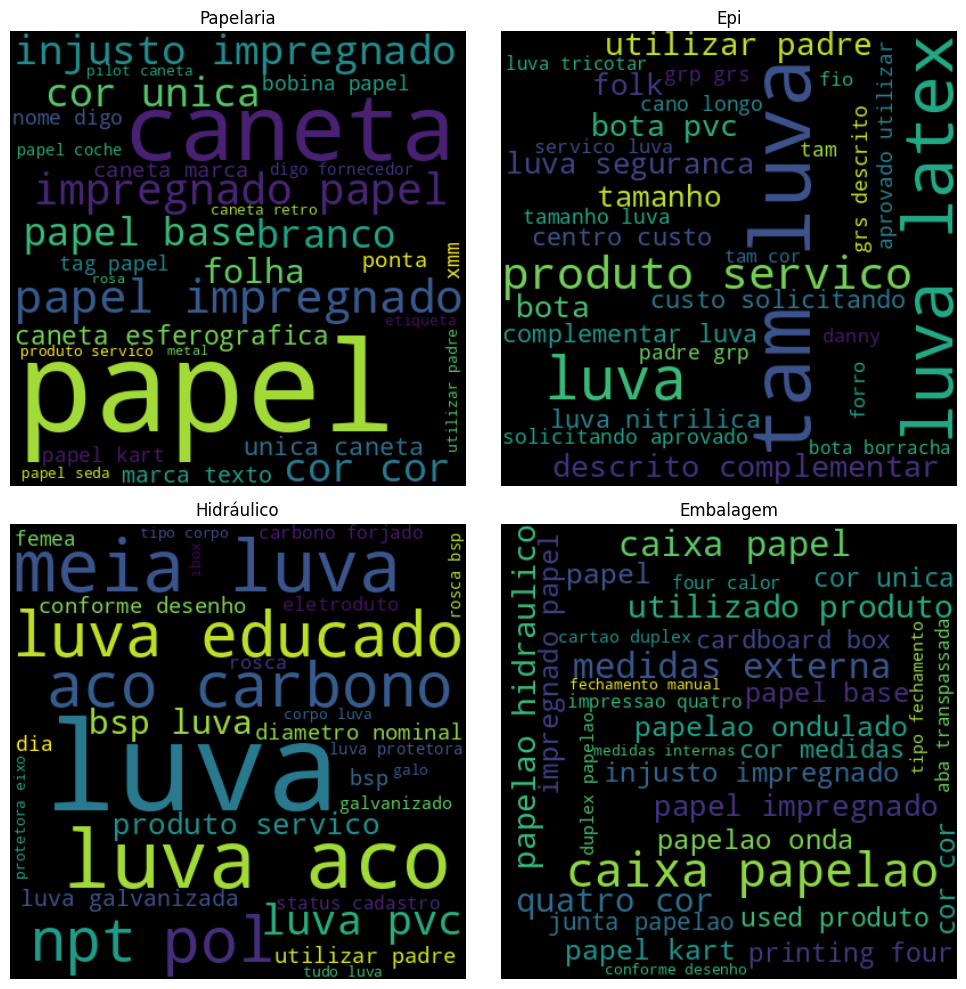

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for idx in range(len(unique_values)):
    # Calcula a respectiva linha e coluna do plot
    row = idx // 2
    col = idx % 2

    category = unique_values[idx]

    # Constroi a lista de palavras da wordcloud
    dfTemp = dfManipulated[dfManipulated['Categoria'] == category].copy()

    # Alimenta a wordcloud e joga no subplot
    wordcloud = WordCloud(width=400, height=400, max_words=30).generate_from_text(' '.join(dfTemp['descricao']))
    axs[row, col].imshow(wordcloud, interpolation='bilinear')
    axs[row, col].axis('off')
    axs[row, col].set_title(category)

plt.tight_layout()
plt.show()

In [75]:
[generate_wordcloud(item) for item in unique_values]

NameError: name 'generate_wordcloud' is not defined

In [76]:
from nltk.tokenize import word_tokenize

In [77]:
def descrica_ngrams(df, n_grams = 2):
  tokens = [word_tokenize(desc) for desc in df['descricao']]

  ngram_list = []
  for tokens in tokens:
    ngram_for_desc = list(ngrams(tokens, n_grams))
    ngram_list.extend(ngram_for_desc)

  n_gram_freq = nltk.FreqDist(ngram_list)

  # Convert bigrams back to strings
  n_gram_strings = [' '.join(ngram) for ngram in n_gram_freq]

  # Get the top N most common bigrams and their frequencies
  top_n = 10
  top_ngrams = n_gram_freq.most_common(top_n)

  # Extract bigram labels and frequencies for the bar chart
  ngram_labels = [' '.join(ngram) for ngram, freq in top_ngrams]
  ngram_frequencies = [freq for ngram, freq in top_ngrams]

  return ngram_labels, ngram_frequencies

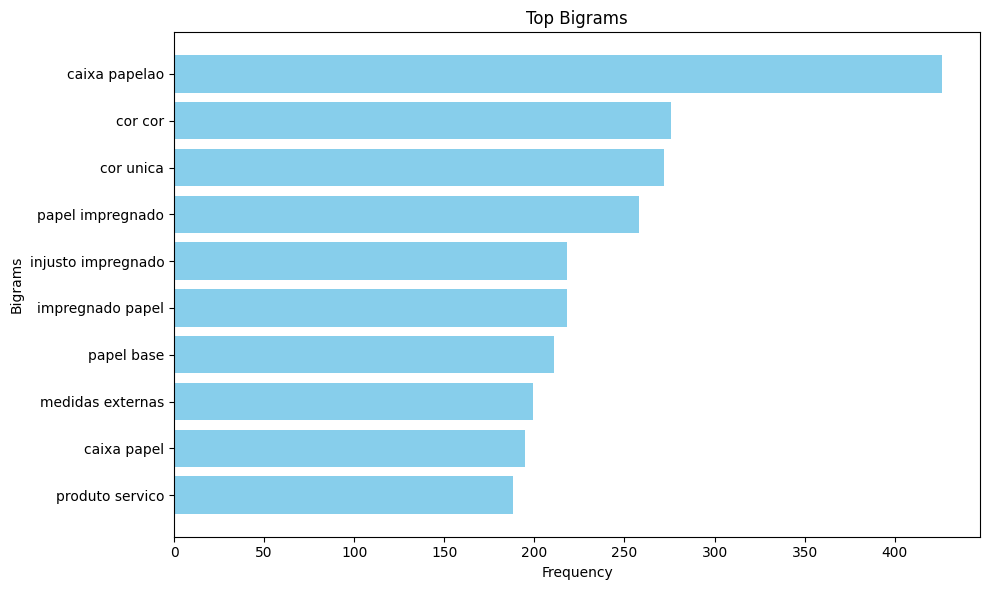

In [78]:
# Create a horizontal bar chart
bigram_labels, bigram_frequencies = descrica_ngrams(dfManipulated, 2)
plt.figure(figsize=(10, 6))
plt.barh(bigram_labels, bigram_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top Bigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.tight_layout()
plt.show()

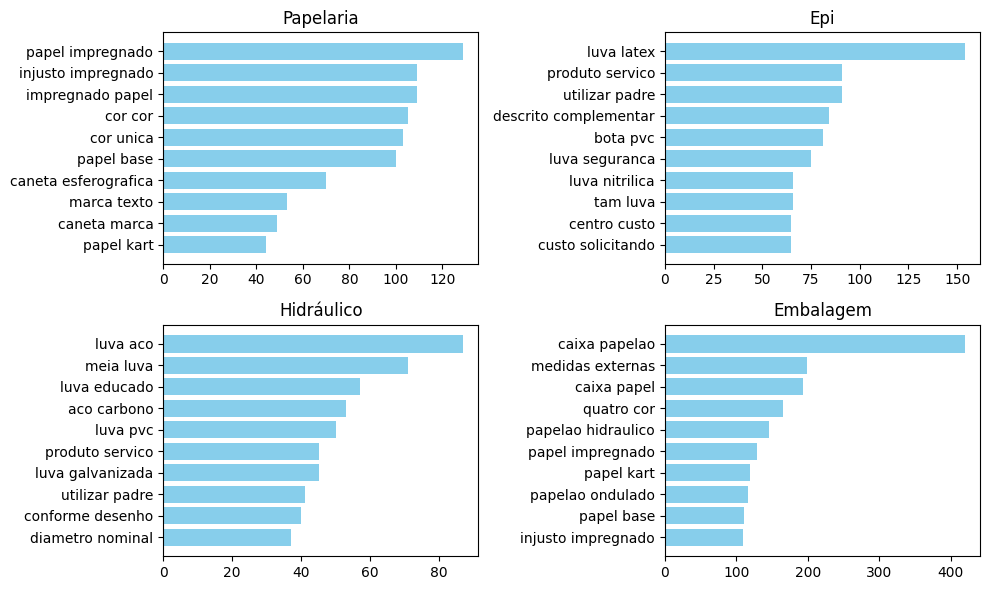

In [79]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for idx in range(len(unique_values)):
    # Calcula a respectiva linha e coluna do plot
    row = idx // 2
    col = idx % 2

    category = unique_values[idx]

    # Constroi a lista de palavras da wordcloud
    dfTemp = dfManipulated[dfManipulated['Categoria'] == category].copy()

    bigram_labels, bigram_frequencies = descrica_ngrams(dfTemp, 2)

    # Create a horizontal bar chart
    axs[row, col].barh(bigram_labels, bigram_frequencies, color='skyblue')
    axs[row, col].set_title(category)
    axs[row, col].invert_yaxis()

plt.tight_layout()
plt.show()

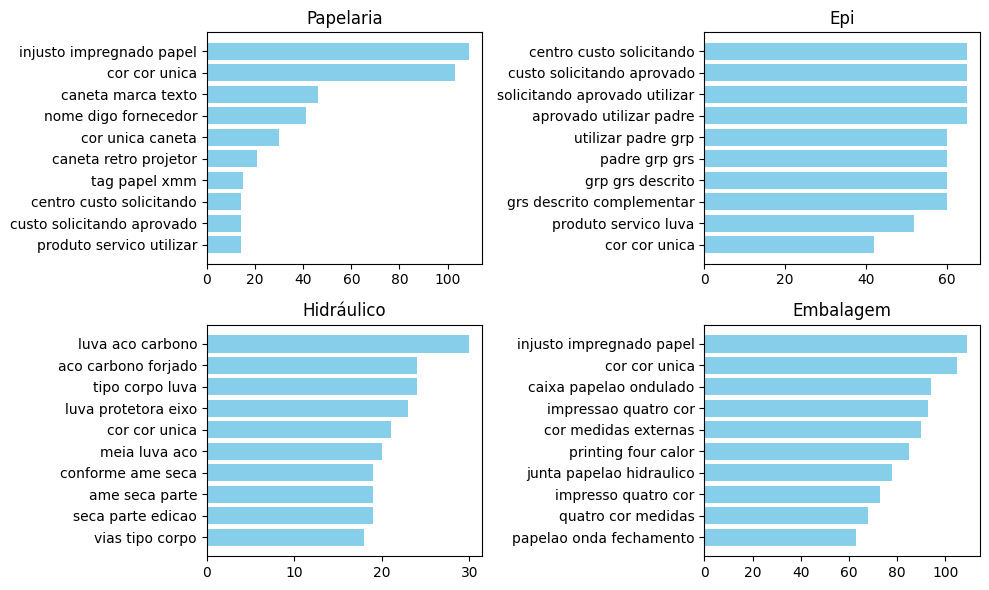

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for idx in range(len(unique_values)):
    # Calcula a respectiva linha e coluna do plot
    row = idx // 2
    col = idx % 2

    category = unique_values[idx]

    # Constroi a lista de palavras da wordcloud
    dfTemp = dfManipulated[dfManipulated['Categoria'] == category].copy()

    bigram_labels, bigram_frequencies = descrica_ngrams(dfTemp, 3)

    # Create a horizontal bar chart
    axs[row, col].barh(bigram_labels, bigram_frequencies, color='skyblue')
    axs[row, col].set_title(category)
    axs[row, col].invert_yaxis()

plt.tight_layout()
plt.show()

## MODELAGEM

In [42]:
le = preprocessing.LabelEncoder()
le.fit(dfManipulated['Categoria'])
dfManipulated['Categoria'] = le.transform(dfManipulated['Categoria'])

In [43]:
dfManipulated.head()

,descricao,Categoria
0,caneta bic cristal,3
1,caneta bic cristal,3
2,caneta bic cristal,3
3,caneta bic cristal,3
4,caneta bic cristal,3


In [44]:
# Feature-target split
X, y = dfManipulated.drop('Categoria', axis = 1), dfManipulated['Categoria']

# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set, validation set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set, validation set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

In [45]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train['descricao'].tolist())
X_val_tfidf = TfidfVec.transform(X_val['descricao'].tolist())
X_test_tfidf = TfidfVec.transform(X_test['descricao'].tolist())

In [46]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
    "Catboost Classifier"
]

models = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    CatBoostClassifier(verbose=False)
]

In [47]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, X_test, y_test, names = names, models = models):
    score_df, score_train, score_val, score_test = pd.DataFrame(), [], [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred, y_test_pred = model.predict(X_train), model.predict(X_val), model.predict(X_test)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))
        score_test.append(accuracy_score(y_test, y_test_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"], score_df["Test accuracy"] = names, score_train, score_val, score_test
    score_df.sort_values(by = 'Test accuracy', ascending = False, inplace = True)
    return score_df

In [48]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy,Test accuracy
3,Linear SVM,0.934324,0.889228,0.879065
5,SGD Classifier,0.934832,0.890244,0.877033
7,XGBoost,0.930894,0.887195,0.877033
0,Logistic Regression,0.931275,0.888211,0.872967
6,Ridge Classifier,0.935467,0.889228,0.872967
4,Random Forest,0.948679,0.880081,0.863821
9,Catboost Classifier,0.920859,0.888211,0.852642
1,KNN Classifier,0.850991,0.858740,0.846545
2,Decision Tree,0.948806,0.867886,0.845528
8,AdaBoost,0.555386,0.581301,0.564024


## Modelagem XGBoost

    n_estimators: O número de árvores de decisão no ensemble.
    learning_rate: A taxa de aprendizado que controla o quanto cada árvore contribui para a previsão final.
    max_depth: A profundidade máxima de cada árvore.
    min_child_weight: O mínimo de amostras necessárias para criar um novo nó em uma árvore.
    subsample: A fração de exemplos usados para treinar cada árvore.
    colsample_bytree e colsample_bylevel: A fração de recursos usados para treinar cada árvore e em cada nível.
    gamma: Um parâmetro de regularização que controla a complexidade do modelo.
    lambda e alpha: Parâmetros de regularização L1 e L2.

In [56]:
def xgboost(params_xgb):    
    xgb = XGBClassifier()
    best_model_xgb, best_params_xgb, best_score_xgb, count = xgb, ParameterGrid(params_xgb)[0], 0, 0
    for g in ParameterGrid(params_xgb):
        time_start = time.time()
        count += 1
        #print(f"Gridpoint #{count}: {g}")
        xgb.set_params(**g)
        xgb.fit(X_train_tfidf, y_train)
        y_train_pred, y_val_pred = xgb.predict(X_train_tfidf), xgb.predict(X_val_tfidf)
        score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
        time_stop = time.time()
        m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
        #print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
        #print(" ")
        if score_val > best_score_xgb:
            best_params_xgb, best_score_xgb = g, score_val

    best_model_tfidf, best_params_tfidf, best_score_tfidf = XGBClassifier(), best_params_xgb, best_score_xgb
    best_model_tfidf.set_params(**best_params_tfidf)
    print(f"Best model: {best_model_tfidf}")
    print(" ")
    print(f"Best parameters: {best_params_tfidf}")
    print(f"Best validation accuracy: {best_score_tfidf}")


In [57]:
params_xgb = {
    'learning_rate': [0.03, 0.3],
    'min_child_weight': [0, 10],
    'n_estimators': [200],
    'reg_lambda': [1, 2],
    'seed': [40]
}

xgboost(params_xgb)

Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
 
Best parameters: {'learning_rate': 0.3, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40}
Best validation accuracy: 0.8851626016260162


In [59]:
params_xgb = {    
    'learning_rate': [0.4],
    'min_child_weight': [0, 10],
    'n_estimators': [200],
    'reg_lambda': [1, 2],
    'seed': [40]
}

xgboost(params_xgb)

Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
 
Best parameters: {'learning_rate': 0.4, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 1, 'seed': 40}
Best validation accuracy: 0.8780487804878049


In [61]:
params_xgb = {    
    'learning_rate': [0.3],
    'min_child_weight': [0],
    'n_estimators': [200],
    'reg_lambda': [2],
    'seed': [40],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9],
}

xgboost(params_xgb)

Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
 
Best parameters: {'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 200, 'reg_lambda': 2, 'seed': 40, 'subsample': 0.9}
Best validation accuracy: 0.883130081300813


## Modelagem Linear SVM

In [85]:
# Hyperparameter tuning for linear SVM
svm_classifier = svm.SVC()
params_svm = {
    'kernel': ['linear'],
    'C': [0.01, 0.1, 1, 10, 100],
    'tol': [1e-3, 1e-4, 1e-5]
}

best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0

for g in ParameterGrid(params_svm):
    time_start = time.time()
    count += 1
    #print(f"Gridpoint #{count}: {g}")
    svm_classifier.set_params(**g)
    svm_classifier.fit(X_train_tfidf, y_train)
    y_train_pred, y_val_pred, y_test_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf), svm_classifier.predict(X_test_tfidf)
    score_train, score_val, score_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred), accuracy_score(y_test, y_test_pred)
    time_stop = time.time()
    m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
    #print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
    #print(" ")
    if score_test > best_score_svm:
        best_params_svm, best_score_svm = g, score_test

best_model_tfidf, best_params_tfidf, best_score_tfidf = svm.SVC(), best_params_svm, best_score_svm
best_model_tfidf.set_params(**best_params_tfidf)
print(f"Best model: {best_model_tfidf}")
print(" ")
print(f"Best parameters: {best_params_tfidf}")
print(f"Best validation accuracy: {best_score_tfidf}")

Best model: SVC(C=1, kernel='linear')
 
Best parameters: {'C': 1, 'kernel': 'linear', 'tol': 0.001}
Best validation accuracy: 0.8324225865209471


In [ ]:
svm_classifier = svm.SVC()
svm_classifier.set_params(C = 10, kernel = 'linear', tol = 0.001)
svm_classifier.fit(X_train_tfidf, y_train)
y_train_pred, y_val_pred, y_test_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf), svm_classifier.predict(X_test_tfidf)
score_train, score_val, score_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred), accuracy_score(y_test, y_test_pred)

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
cm

array([[139,   0,  56,   0],
       [  0, 109,   0,   4],
       [ 38,   0, 150,   0],
       [  0,  13,   0,  75]], dtype=int64)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Embalagem', 'Epi', 'Papelaria', 'Hidráulico'], 
                     columns = ['Embalagem', 'Epi', 'Papelaria', 'Hidráulico'])

NameError: name 'cm' is not defined

In [ ]:
categoria = le.inverse_transform(dfManipulated['Categoria'])

ValueError: y contains previously unseen labels: ['Embalagem' 'Epi' 'Hidráulico' 'Papelaria']

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(14,12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

NameError: name 'cm_df' is not defined

<Figure size 1400x1200 with 0 Axes>

## Modelagem Castboost Classifier

In [ ]:
%%time
# Modelo Base CatBoost Classifier
modelo_cat = CatBoostClassifier(iterations = 50, eval_metric = 'MultiClass', metric_period = 50, learning_rate = 0.01, verbose = False)

CPU times: user 56 µs, sys: 493 µs, total: 549 µs
Wall time: 631 µs


In [ ]:
modelo_cat.fit(X_train_tfidf, y_train)

In [ ]:
y_train_pred, y_val_pred, y_test_pred = modelo_cat.predict(X_train_tfidf), modelo_cat.predict(X_val_tfidf), modelo_cat.predict(X_test_tfidf)
score_train, score_val, score_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred), accuracy_score(y_test, y_test_pred)

In [ ]:
print(f"Best validation accuracy: {score_test}")

Best validation accuracy: 0.6988188976377953


In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
cm

array([[ 73,   0,   0,  68],
       [  0, 124,   0,   4],
       [  0,  74,   7,   1],
       [  6,   0,   0, 151]])

#Modelo CNN

In [182]:

#Melhor configuração para este modelo
# Acurácia no Conjunto de Validação: 0.9350
# cov1d_filters: 17.0000
# dense_units: 9.0000
# dropout: 0.1000

from keras.layers import Dropout

#X = dfManipulated['descricao']
#y = dfManipulated['Categoria']


X = df_sem_duplicatas['descricao']
y = df_sem_duplicatas['Categoria']
# Codificar as categorias em números
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# Dividir os dados em conjunto de treino e conjunto de teste
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenização
max_words = 1000  # Número máximo de palavras no vocabulário
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding para ter sequências com o mesmo comprimento
maxlen = 100  # Comprimento máximo de uma sequência
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)

# Construção do modelo CNN
#model = Sequential()
#model.add(Embedding(input_dim=max_words, output_dim=100, input_length=maxlen))
#model.add(Conv1D(128, 5, activation='relu'))
#model.add(GlobalMaxPooling1D())
#model.add(Dense(64, activation='relu'))
#model.add(Dense(len(label_encoder.classes_), activation='softmax'))

dropout = 0.01
initial_output_dim = 10
initial_cov1d_filters = 16
initial_dense_units = 8
increment = True
i = 1
epochs =10
while increment:
    output_dim = initial_output_dim + i 
    cov1d_filters = initial_cov1d_filters + i
    dense_units = initial_dense_units + i 
   # epochs = epochs +1
    
    if(i == 50):
        dropout = dropout  + 0.01
    #Construção do modelo CNN com Dropout
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=output_dim, input_length=maxlen))
    model.add(Conv1D(cov1d_filters, 5, activation='relu'))
    model.add(Dropout(dropout))  # Adicionando dropout após a camada Conv1D
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout))  # Adicionando dropout após a camada Dense
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
   
        
    # Compilar o modelo
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Treinar o modelo
    model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=epochs, batch_size=32)

    # Avaliar o modelo
    y_val_pred_probs = model.predict(X_val_pad)
    y_val_pred = y_val_pred_probs.argmax(axis=1)
    val_accuracy = accuracy_score(y_val.argmax(axis=1), y_val_pred)
    print(f"Acurácia no Conjunto de Validação: {val_accuracy:.4f}")
    print(f"Output dim: {output_dim:.4f}")
    print(f"cov1d_filters: {cov1d_filters:.4f}")
    print(f"dense_units: {dense_units:.4f}")
    print(f"dropout: {dropout:.4f}")
   
    if val_accuracy >= 0.93:
        increment = False
        print("Atingida acurácia desejada. Encerrando as iterações.")
        break
    
    i += 1


Epoch 1/10
127/127 [==============================] - 0s 2ms/step - loss: 1.2904 - accuracy: 0.5214 - val_loss: 0.9970 - val_accuracy: 0.7517
Epoch 2/10
127/127 [==============================] - 0s 2ms/step - loss: 0.6240 - accuracy: 0.7756 - val_loss: 0.3694 - val_accuracy: 0.8601
Epoch 3/10
127/127 [==============================] - 0s 2ms/step - loss: 0.2906 - accuracy: 0.8992 - val_loss: 0.2242 - val_accuracy: 0.9261
Epoch 4/10
127/127 [==============================] - 0s 2ms/step - loss: 0.2017 - accuracy: 0.9169 - val_loss: 0.2031 - val_accuracy: 0.9232
Epoch 5/10
127/127 [==============================] - 0s 2ms/step - loss: 0.1699 - accuracy: 0.9305 - val_loss: 0.1809 - val_accuracy: 0.9320
Epoch 6/10
127/127 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.9435 - val_loss: 0.1745 - val_accuracy: 0.9360
Epoch 7/10
127/127 [==============================] - 0s 2ms/step - loss: 0.1350 - accuracy: 0.9500 - val_loss: 0.1737 - val_accuracy: 0.9310
Epoch 

In [183]:
print(f"Acurácia no Conjunto de Validação: {val_accuracy:.4f}")
print("Relatório de Classificação:")
print(classification_report(y_val.argmax(axis=1), y_val_pred))

Acurácia no Conjunto de Validação: 0.9320
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       282
           1       0.93      0.96      0.94       270
           2       0.91      0.87      0.89       141
           3       0.94      0.94      0.94       322

    accuracy                           0.93      1015
   macro avg       0.93      0.92      0.93      1015
weighted avg       0.93      0.93      0.93      1015



In [187]:
# Prepare data
X = df_sem_duplicatas['descricao']
y = df_sem_duplicatas['Categoria']

# Encode categories to numbers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequencesX_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)


maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)

dropout = 0.1
initial_output_dim = 10
initial_cov1d_filters = 16
initial_dense_units = 8
increment = True
i = 1
epochs = 10

while increment:
    output_dim = initial_output_dim + i
    cov1d_filters = initial_cov1d_filters + i
    dense_units = initial_dense_units + i

    if i == 50:
        dropout += 0.01


    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=output_dim, input_length=maxlen))
    model.add(Conv1D(cov1d_filters, 5, activation='relu'))
    model.add(Dropout(dropout))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1], activation='softmax'))

   
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  
    model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=epochs, batch_size=32, verbose=1)

   
    _, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)

    print(f"Acurácia no Conjunto de Validação: {val_accuracy:.4f}")
    print(f"Output dim: {output_dim:.4f}")
    print(f"cov1d_filters: {cov1d_filters:.4f}")
    print(f"dense_units: {dense_units:.4f}")
    print(f"dropout: {dropout:.4f}")

    if val_accuracy >= 0.93:
        increment = False
        print("Atingida acurácia desejada. Encerrando as iterações.")

    i += 1

Epoch 1/10
127/127 [==============================] - 1s 2ms/step - loss: 1.2670 - accuracy: 0.4352 - val_loss: 0.9891 - val_accuracy: 0.6621
Epoch 2/10
127/127 [==============================] - 0s 2ms/step - loss: 0.5735 - accuracy: 0.8129 - val_loss: 0.2789 - val_accuracy: 0.9232
Epoch 3/10
127/127 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.9046 - val_loss: 0.1939 - val_accuracy: 0.9281
Epoch 4/10
127/127 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.9189 - val_loss: 0.1819 - val_accuracy: 0.9320
Epoch 5/10
127/127 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.9334 - val_loss: 0.1738 - val_accuracy: 0.9340
Epoch 6/10
127/127 [==============================] - 0s 2ms/step - loss: 0.1693 - accuracy: 0.9342 - val_loss: 0.1768 - val_accuracy: 0.9350
Epoch 7/10
127/127 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.9443 - val_loss: 0.1763 - val_accuracy: 0.9379
Epoch 

In [188]:
print(f"Acurácia no Conjunto de Validação: {val_accuracy:.4f}")
print("Relatório de Classificação:")

# Generate predictions for the validation set
y_val_pred_probs = model.predict(X_val_pad)
y_val_pred = y_val_pred_probs.argmax(axis=1)

# Decode one-hot encoded labels back to categorical labels
y_val_true = label_encoder.inverse_transform(y_val.argmax(axis=1))
y_val_pred = label_encoder.inverse_transform(y_val_pred)
print(classification_report(y_val_true, y_val_pred))

Acurácia no Conjunto de Validação: 0.9369
Relatório de Classificação:
32/32 [==============================] - 0s 612us/step
              precision    recall  f1-score   support

   Embalagem       0.94      0.94      0.94       282
         Epi       0.94      0.95      0.94       270
  Hidráulico       0.90      0.88      0.89       141
   Papelaria       0.95      0.95      0.95       322

    accuracy                           0.94      1015
   macro avg       0.93      0.93      0.93      1015
weighted avg       0.94      0.94      0.94      1015

